# WATER SAMPLES
The Problem: Can we predict which water samples are Potable or Non-Potable?
Data is extracted from https://www.kaggle.com/code/joshuaswords/water-quality-eda-models

## Exploratory Data Analysis (EDA)
Import libraries to read csv and do inital analysis with pandas_profiling

In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score, auc, roc_curve
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

import shap  

In [3]:
df=pd.read_csv('C:/Users/mifab/Documents/Git/Python_DS_Projects/Data/water_potability.csv')
prof = ProfileReport(df)
prof

Summarize dataset:   0%|          | 0/23 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

##### Notes:
1) Dataset fairly small, around 3k rows
2) Potability seems to be the column one would like to predict using the remaining columns. It is a binary, implying in a binary classification problem
3) Columns are numeric characteristic of the water sample whose behaviour we want to predict (in 1 for positive or 0 for negative)
4) We also note that there are 4.4% null values in the dataset in ph and sulfate
5) Most of the distributions seem to be relatively close to normal
6) No clear distinctions can be found
7) Most of the features are highly uncorrelated, sulfate and solids are the most correlated (negative)

## Fill empty null values
As they are >1% of the rows, they are replaced with the mean of each column to avoid losing data by dropping them

In [4]:
numeric_cols=df.select_dtypes(['int64','float64']).columns
numeric_cols

Index(['ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity',
       'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability'],
      dtype='object')

In [39]:
imputer=SimpleImputer(strategy='mean')
imputer.fit(df[numeric_cols])
df[numeric_cols] = imputer.transform(df[numeric_cols])

In [6]:
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

## See Proportion of Classes and Downsample

The EDA revealed difference in the proportion of portability class. In order to avoid biasing the model, we can sub-sample rows to match the number of examples per class.

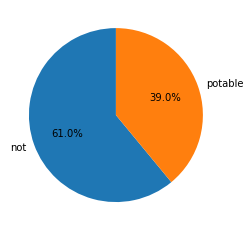

In [8]:
detail= df['Potability'].value_counts()
plt.pie(detail,labels =['not','potable'],autopct='%1.1f%%', startangle = 90)
plt.show()

In [9]:
df_majority = df[df['Potability']==0]
df_minority = df[df['Potability']==1]
len(df_minority)

1278

In [12]:

df_majority_downsampled = resample(df_majority, 
                                 replace=False,
                                 n_samples=len(df_minority),    
                                 random_state=123) 
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled['Potability'].value_counts()

0.0    1278
1.0    1278
Name: Potability, dtype: int64

## Scale the data and split into train and test
In order to improve the training, we first scale each variable via a normalisation (0,1).

Considering we have ~2.5k instances, we will consider a train-test-split of 80-20.

In [13]:
y = df_downsampled['Potability']
X = df_downsampled.drop(['Potability'], axis=1)

standard_scaler = StandardScaler()
X_stand_scaled = standard_scaler.fit_transform(X)
variables =X.columns
X_stand_scaled = pd.DataFrame(X_stand_scaled, columns=variables)
X_stand_scaled.head()

ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
0 -2.367715  0.184207 -1.421921     1.967651 -0.543372      1.451224   
1  0.485696 -0.034470  0.023605    -0.638314  2.261097     -0.664120   
2 -0.317287 -2.505894  0.417246     0.316900 -0.567466     -1.209555   
3  0.078216  0.956471 -0.754029     0.156955  0.041205     -1.607035   
4 -0.645929 -0.895833  0.915679     1.139023  0.014140     -0.909856   

   Organic_carbon  Trihalomethanes  Turbidity  
0        0.355608        -0.068271  -0.150313  
1       -1.001420         0.006992   0.941810  
2        1.561201         1.232039   0.294931  
3       -0.100748        -0.981694   0.177643  
4        0.952969         0.571844  -0.356005

In [14]:
X_train,X_test, y_train, y_test = train_test_split(X_stand_scaled, y, test_size=0.2, random_state=42)

## Train Models and Compare

We set to compare a range of classifiers to obtain the best performance on the dataset

In [16]:
models = {
    "Logistic Regression": LogisticRegression(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "K-Nearest Neighbours": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

In [17]:
model_df = []
accuracy = []
precision = []
recall = []
f1 = []

for model, model_launch in models.items():
    
    # Loop through listed models
    model_initiated = model_launch
    model_initiated.fit(X_train, y_train)
    predictions = model_initiated.predict(X_test)
    
    # Model Names
    model_df.append(model)
    
    # Model Scores
    accuracy.append(accuracy_score(y_test, predictions))
    precision.append(precision_score(y_test, predictions))
    recall.append(recall_score(y_test, predictions))
    f1.append(f1_score(y_test, predictions))
    
    # Model Names & Scores in to a DataFrame
    
    scores_df_stand = pd.DataFrame({'Model':model_df,
                              'Accuracy': accuracy, 
                              'Precision': precision,
                              'Recall': recall,
                              'F1':f1}).sort_values(by='Accuracy', ascending=False)
    
    
    
# Stylised DataFrame to help quickly grasp top performing models across metrics
scores_df_stand

(scores_df_stand.style
  .background_gradient(subset=['Accuracy','Precision','Recall','F1'])
  .highlight_max(subset=['Accuracy','Precision','Recall','F1'], color='gold')
  .set_caption('Model Performance with Standard Scaled X Data')
  .format({'Accuracy': "{:.2%}",
           'Precision': "{:.2%}",
           'Recall': "{:.2%}",
           'F1': "{:.2%}"
          }))

The Random Forest Model obtained the best accuracy of 64.26%. We proceed to evaluate the model further by observing how it ranks features.

## Explain best model with Shapley

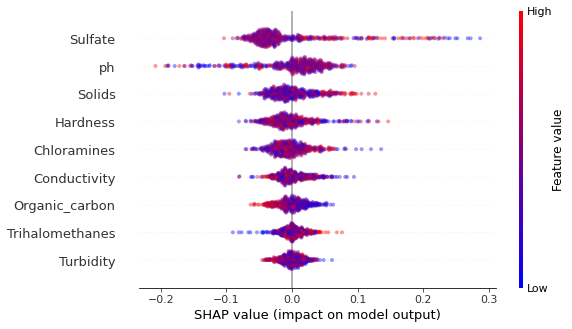

In [33]:
clf3 = models['Random Forest']
clf3.fit(X_train, y_train)
explainer = shap.TreeExplainer(clf3)

# calculate shap values. This is what we will plot.
shap_values = explainer.shap_values(X_test)

colors = ["b", "r"]           
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
shap.summary_plot(shap_values[1], X_test,cmap=cmap,alpha=0.4)

### See Relation Between Top Feature and SHAP

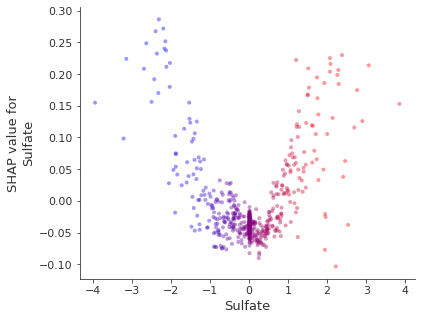

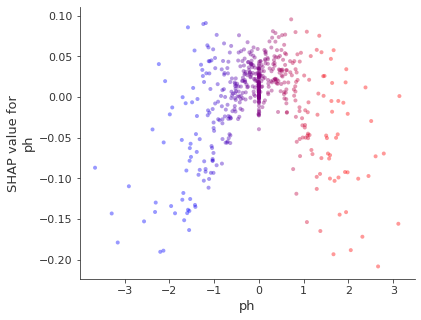

In [38]:
shap.dependence_plot('Sulfate', shap_values[1], X_test, interaction_index="Sulfate",cmap=cmap,alpha=0.4,show=False)
shap.dependence_plot('ph', shap_values[1], X_test, interaction_index="ph",cmap=cmap,alpha=0.4,show=False)

## Conclusions
1) A baseline model was developed to predict the TARGET column. 
3) The Model could be improved via Boosted DT
4) We identified the most important features and some general trends between them that would help in the building of a second version of the model